In [2]:
import torch
print(torch.__version__)          # >= 2.6
print(torch.version.cuda)         # 12.1
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # RTX 3050


2.9.0+cu130
13.0
True
NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

dir(clip_model)

In [4]:
clip_model.num_parameters()

151277313

In [5]:
# Function to get text embedding
def get_text_embedding(text: str):
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    text_embeddings = clip_model.get_text_features(**inputs)
    return text_embeddings

In [6]:
get_text_embedding("sdhdfushdd").shape

torch.Size([1, 512])

In [7]:
from pathlib import Path

In [8]:
images = [] 
images.extend(Path("data/Apparel/Boys/Images/images_with_product_ids").glob("*.jpg"))
images.extend(Path("data/Apparel/Girls/Images/images_with_product_ids").glob("*.jpg"))

In [9]:
len(images)

1326

In [10]:
import numpy as np
from itertools import batched

In [11]:
import torch

In [12]:

from torchvision.utils import make_grid
from torchvision.io import read_image 
from torchvision import transforms

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [14]:
def get_text_embedding(text):
    # Prepare input and move to GPU
    inputs = clip_processor(text=[text], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Compute text embeddings on GPU
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**inputs)

    # Move embedding to CPU
    return text_embeddings[0].cpu()

def load_transform_images(image_paths):
    target_size = (240, 240)
    reshape_transform = lambda image_tensor: transforms.Resize(target_size)(image_tensor).expand(3, -1, -1)
    images = [reshape_transform(read_image(image)) for image in image_paths]
    return images

def get_image_embeddings(image_paths):
    # Load and preprocess images (your function)
    images = load_transform_images(image_paths)

    # Prepare inputs
    inputs = clip_processor(images=images, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # move inputs to GPU

    # Compute embeddings on GPU
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(**inputs)

    # Move embeddings back to CPU for saving
    return image_embeddings.cpu()

In [15]:
import torch, psutil, os

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("Total VRAM:", torch.cuda.get_device_properties(0).total_memory // 1e9, "GB")

print("System RAM:", psutil.virtual_memory().total // 1e9, "GB")


CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Total VRAM: 4.0 GB
System RAM: 16.0 GB


In [16]:
import os

save_dir = "data/fashion-images/embeddings"
os.makedirs(save_dir, exist_ok=True)  # creates folder if it doesn't exist


In [17]:
batch_size = 500
total_batches = int(np.ceil(len(images)/batch_size))

i = 0
embedding_files = []
for image_fps in batched(images, batch_size):
    i += 1
    print(f"Processing batch {i}/{total_batches}")
    file_name = os.path.join(save_dir, f"batch_{i}.pt")
    torch.save(get_image_embeddings(image_fps), file_name)
    embedding_files.append(file_name)

Processing batch 1/3
Processing batch 2/3
Processing batch 3/3


In [18]:
embedding_files

['data/fashion-images/embeddings\\batch_1.pt',
 'data/fashion-images/embeddings\\batch_2.pt',
 'data/fashion-images/embeddings\\batch_3.pt']

In [19]:

image_embeddings = torch.cat([torch.load(fp) for fp in embedding_files])

In [20]:
image_embeddings.shape

torch.Size([1326, 512])

In [21]:
image_embeddings[0]

tensor([ 3.2865e-01, -2.5626e-02,  2.3251e-01,  2.4844e-01,  1.0263e-01,
         4.9560e-01, -2.2405e-01, -9.5958e-02,  3.1246e-01,  2.1700e-01,
         1.1739e-01,  2.0192e-01,  5.3473e-01,  1.4411e-01, -1.3451e-01,
        -1.1842e-01,  1.5426e+00,  1.8423e-01,  4.2935e-01, -3.9448e-01,
         1.5006e-01,  1.1215e-01, -3.6660e-01, -6.5848e-01, -1.9153e-01,
         1.3958e-01, -8.1756e-01, -1.2558e-01, -3.3180e-02, -1.5632e-01,
         6.0532e-02,  4.7768e-01, -1.1487e-01,  5.2216e-02, -1.6637e-01,
        -3.6490e-01, -3.3736e-01,  3.1282e-01,  1.3672e-01,  1.3835e+00,
        -1.5229e-01, -2.4473e-01, -2.1564e-01, -4.2721e-01, -5.9941e-02,
         3.4765e-01,  5.7393e-02, -2.6151e-01,  5.1517e-01, -2.7512e-01,
         3.4478e-01, -7.0080e-02,  2.8053e-01, -2.1379e-01,  1.7358e-01,
         4.0397e-01,  1.6391e-01,  1.3403e-01, -3.7195e-01,  2.4367e-01,
         1.1487e+00, -3.3406e-01, -1.9224e-02,  3.6765e-01, -5.4470e-01,
         2.9878e-01,  4.3380e-01, -3.5490e-01, -5.3

In [22]:
sum(image_embedding.element_size() for image_embedding in image_embeddings) / 1e3 # kb

5.304

In [23]:
from tqdm import tqdm

In [24]:
def rank_items(text_embedding: torch.Tensor, image_embeddings: torch.Tensor):
    scores = []
    cosine_similarity = torch.nn.CosineSimilarity()
    for image_embedding in tqdm(image_embeddings):
        score = cosine_similarity(text_embedding.unsqueeze(dim=0), image_embedding.unsqueeze(dim=0))
        scores.append(float(score))
    return scores

In [33]:
scores = rank_items(get_text_embedding("Red coloured Checkered Shirt for Boys"), image_embeddings)

100%|██████████| 1326/1326 [00:00<00:00, 22831.25it/s]


In [34]:
scores

[0.15942907333374023,
 0.2403102070093155,
 0.18494179844856262,
 0.24333274364471436,
 0.25703051686286926,
 0.2560808062553406,
 0.2359868735074997,
 0.2505638003349304,
 0.20057569444179535,
 0.16949857771396637,
 0.1480722278356552,
 0.1793220043182373,
 0.21128016710281372,
 0.1925523579120636,
 0.18025870621204376,
 0.1967746466398239,
 0.20326028764247894,
 0.18018825352191925,
 0.22138711810112,
 0.2227327525615692,
 0.22931645810604095,
 0.24576020240783691,
 0.22185158729553223,
 0.16786827147006989,
 0.22996769845485687,
 0.1698637455701828,
 0.17269489169120789,
 0.20891694724559784,
 0.20856794714927673,
 0.21283859014511108,
 0.19574330747127533,
 0.18387213349342346,
 0.17788980901241302,
 0.2317626029253006,
 0.19597604870796204,
 0.18354254961013794,
 0.20525749027729034,
 0.19841782748699188,
 0.18734745681285858,
 0.19645623862743378,
 0.2179049402475357,
 0.18387213349342346,
 0.17788980901241302,
 0.2317468822002411,
 0.19384141266345978,
 0.19599206745624542,
 0.1

In [35]:
np.argsort(scores)

array([884, 220, 262, ..., 101, 194, 195], shape=(1326,))

In [36]:
idx = np.argsort(scores)
np.array(scores)[idx][::-1]

array([0.35374072, 0.35374072, 0.35374072, ..., 0.12733313, 0.12711668,
       0.12504792], shape=(1326,))

In [37]:
idx = np.argsort(scores)
np.array(images)[idx][::-1]

array([WindowsPath('data/Apparel/Boys/Images/images_with_product_ids/34039.jpg'),
       WindowsPath('data/Apparel/Boys/Images/images_with_product_ids/34038.jpg'),
       WindowsPath('data/Apparel/Boys/Images/images_with_product_ids/31098.jpg'),
       ...,
       WindowsPath('data/Apparel/Boys/Images/images_with_product_ids/35455.jpg'),
       WindowsPath('data/Apparel/Boys/Images/images_with_product_ids/34100.jpg'),
       WindowsPath('data/Apparel/Girls/Images/images_with_product_ids/33270.jpg')],
      shape=(1326,), dtype=object)

In [38]:
i = 0
for image in np.array(images)[idx][::-1]:
    i += 1
    print(image)
    if i >= 5:
        break

data\Apparel\Boys\Images\images_with_product_ids\34039.jpg
data\Apparel\Boys\Images\images_with_product_ids\34038.jpg
data\Apparel\Boys\Images\images_with_product_ids\31098.jpg
data\Apparel\Boys\Images\images_with_product_ids\46831.jpg
data\Apparel\Boys\Images\images_with_product_ids\34040.jpg


In [39]:
from IPython.display import display
from IPython.display import Image as DisplayImage

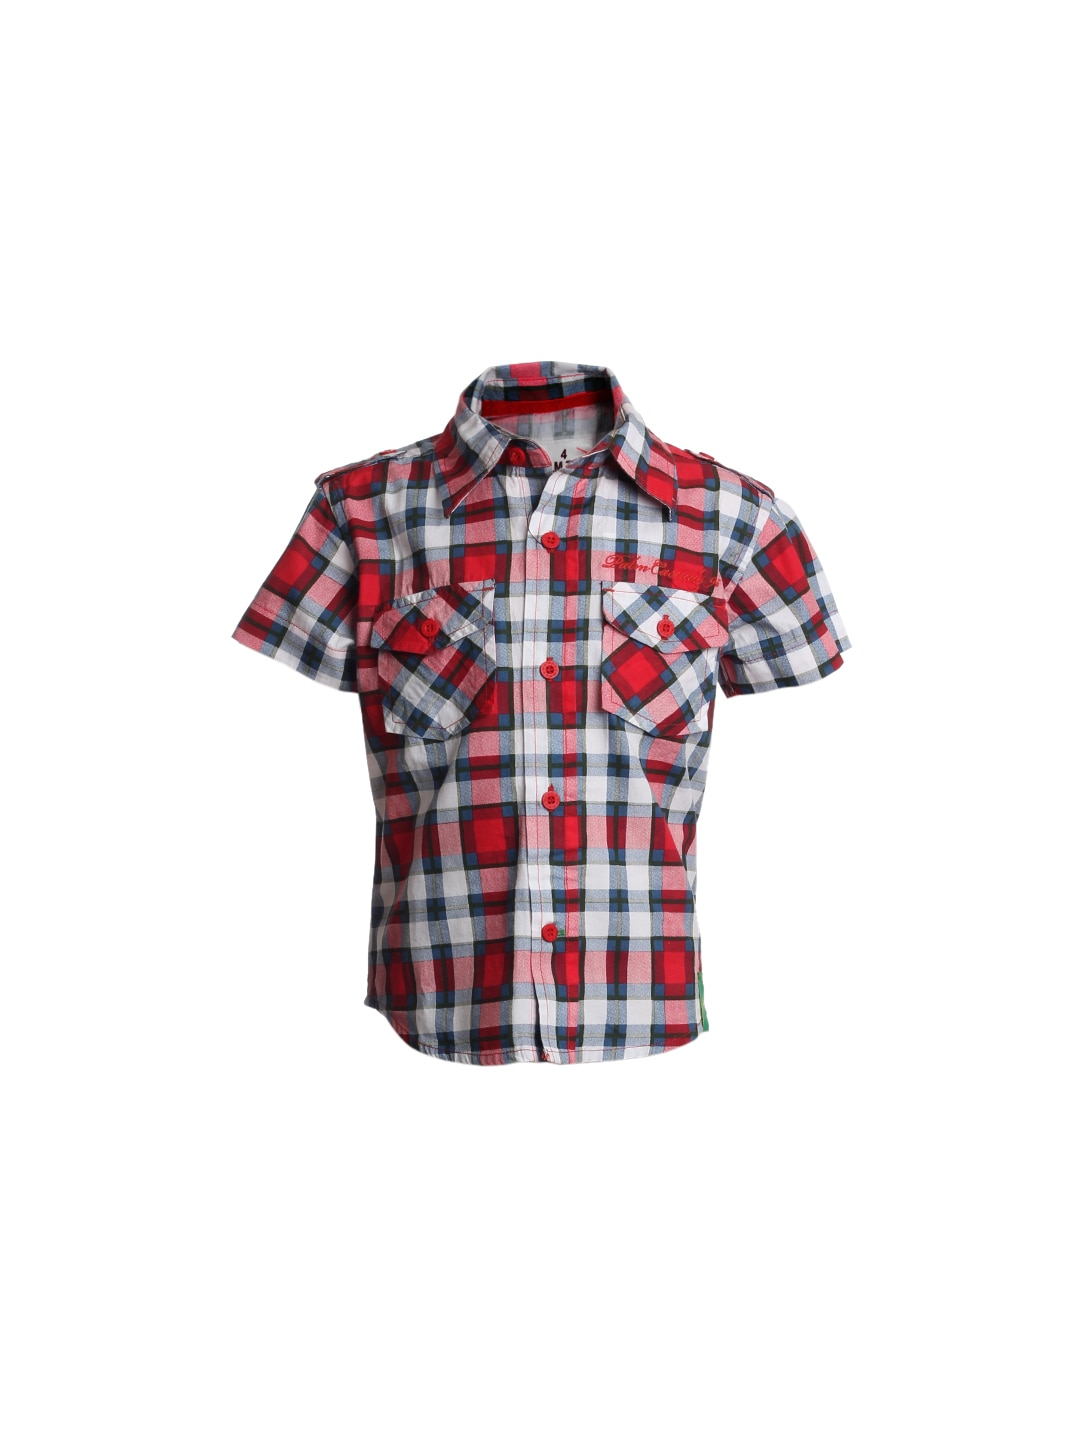

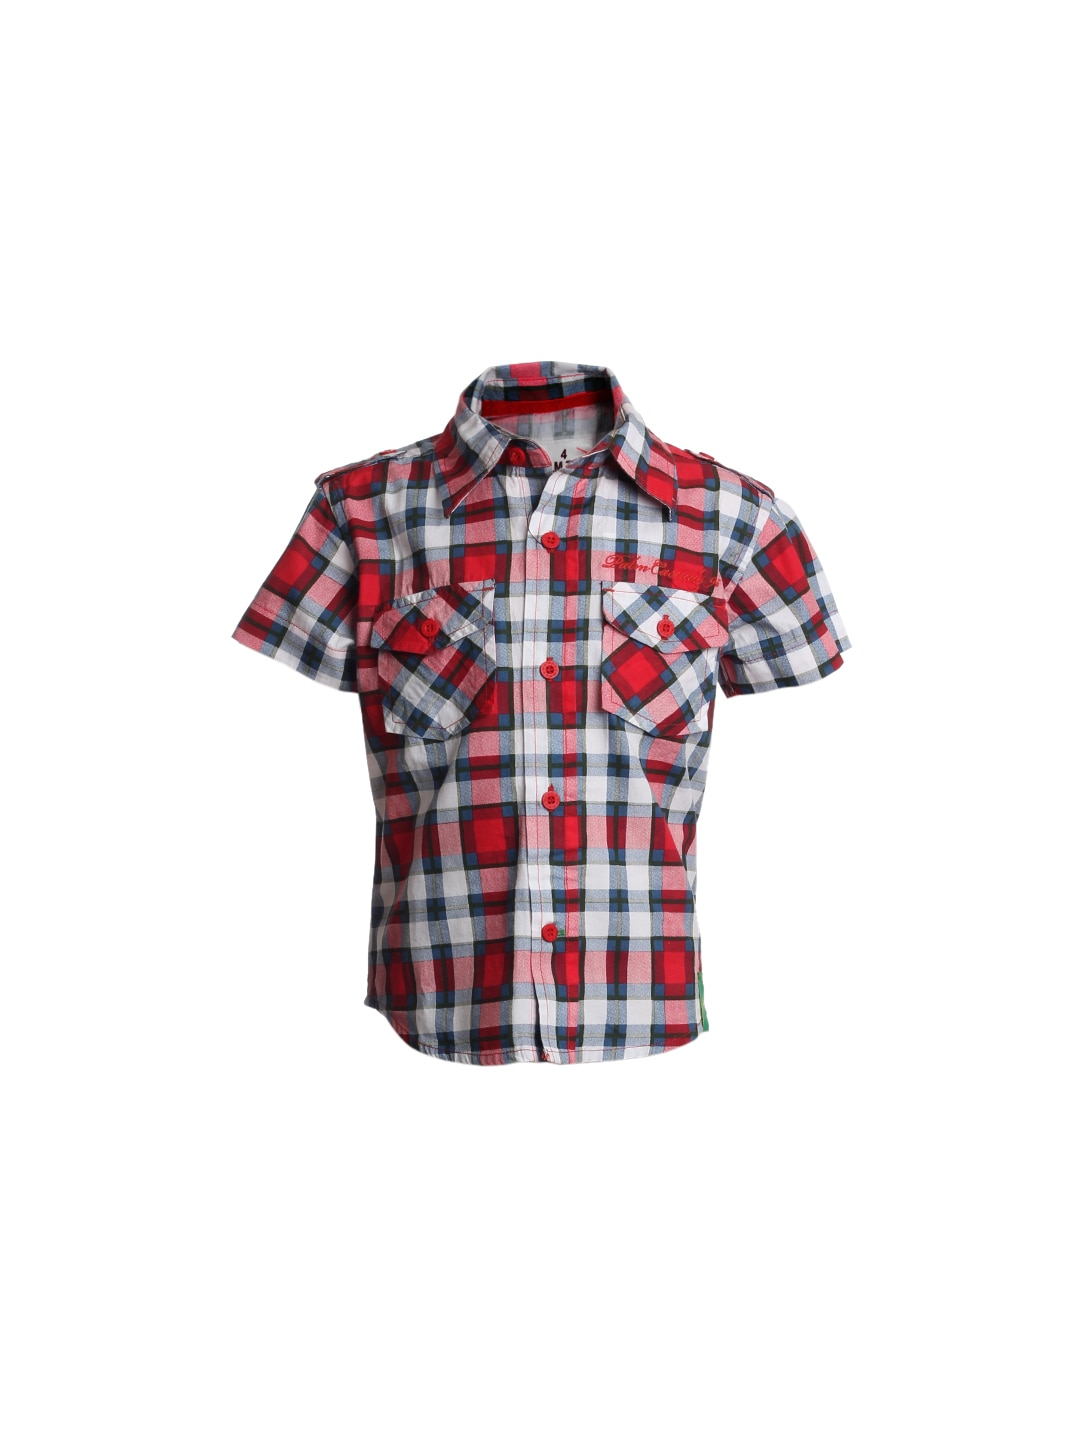

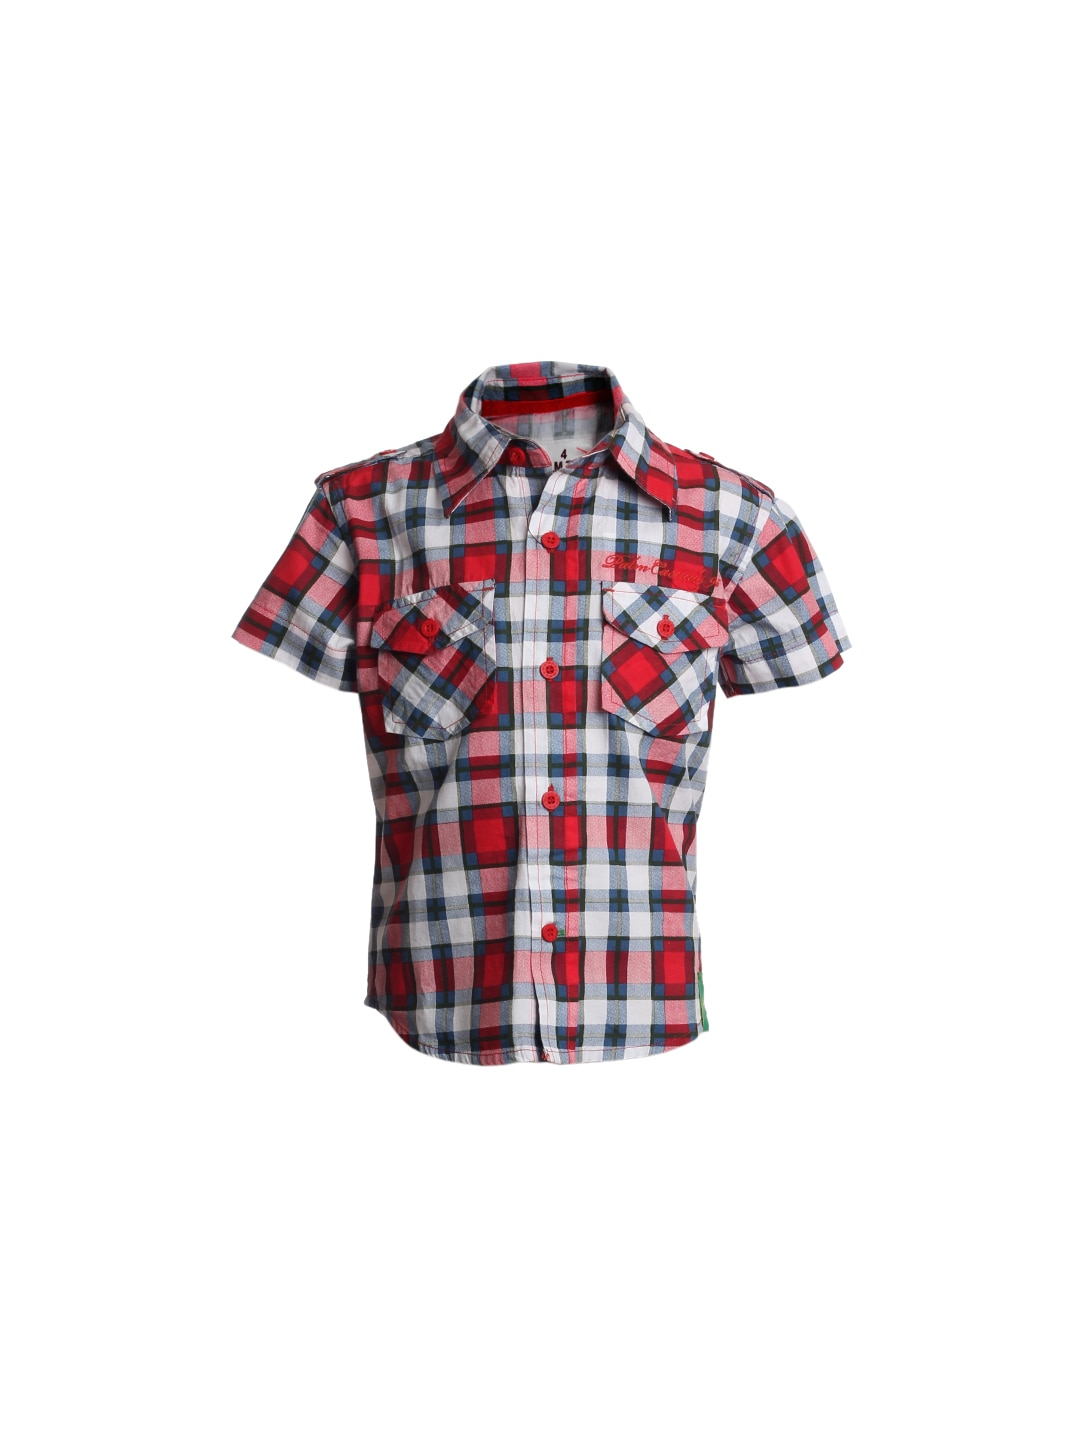

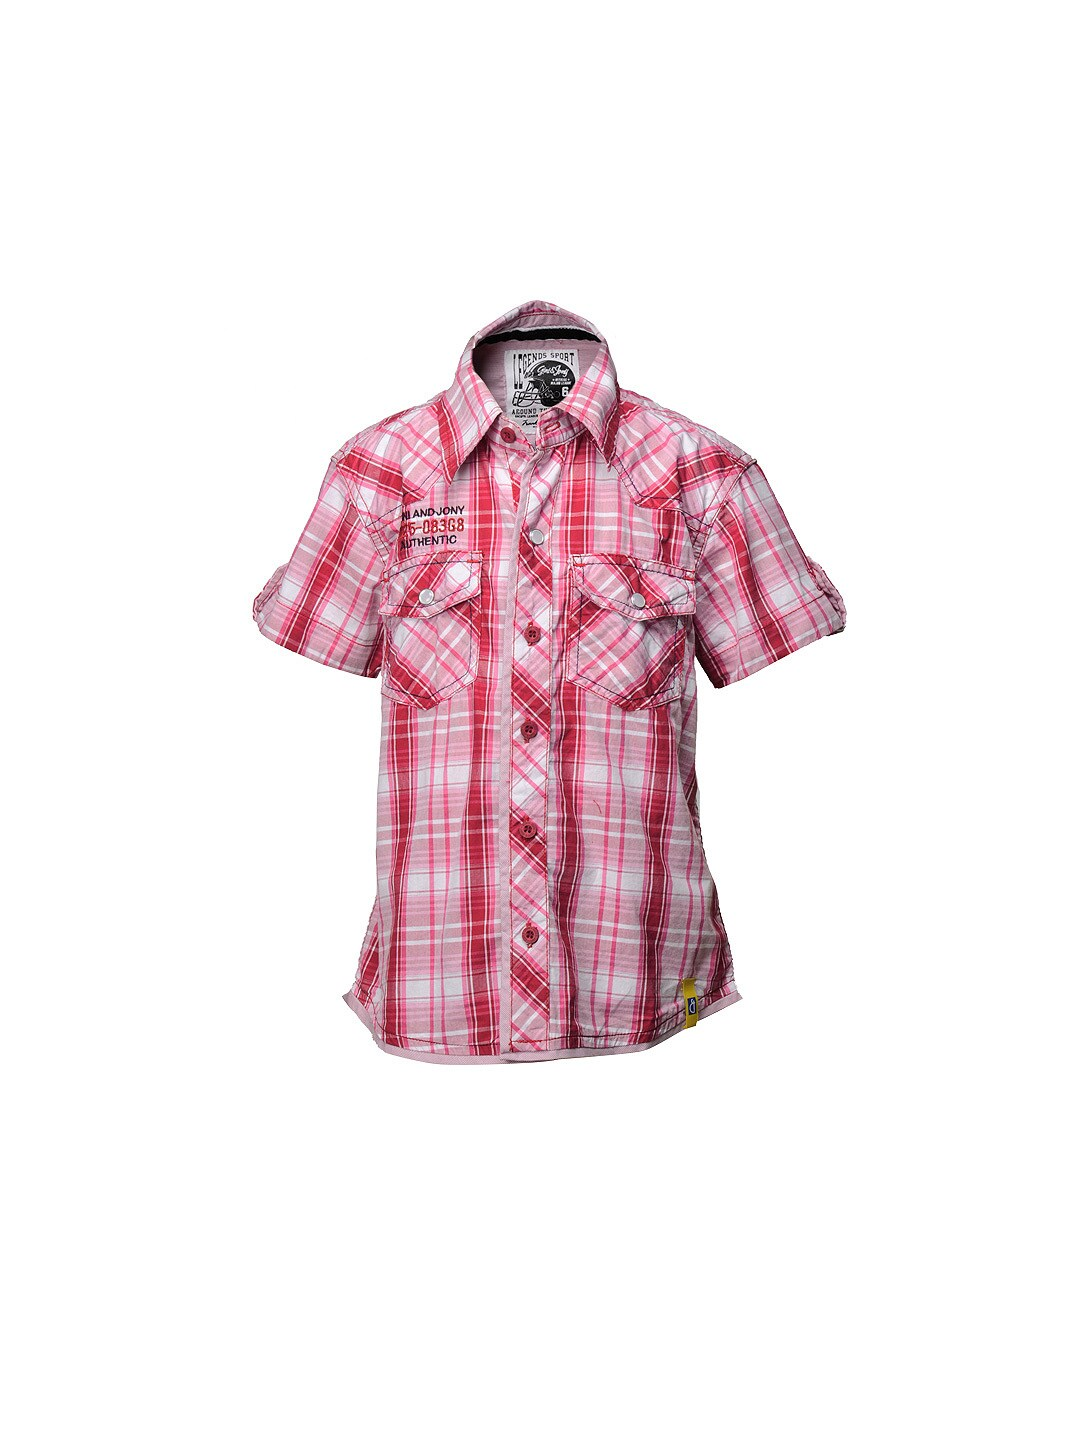

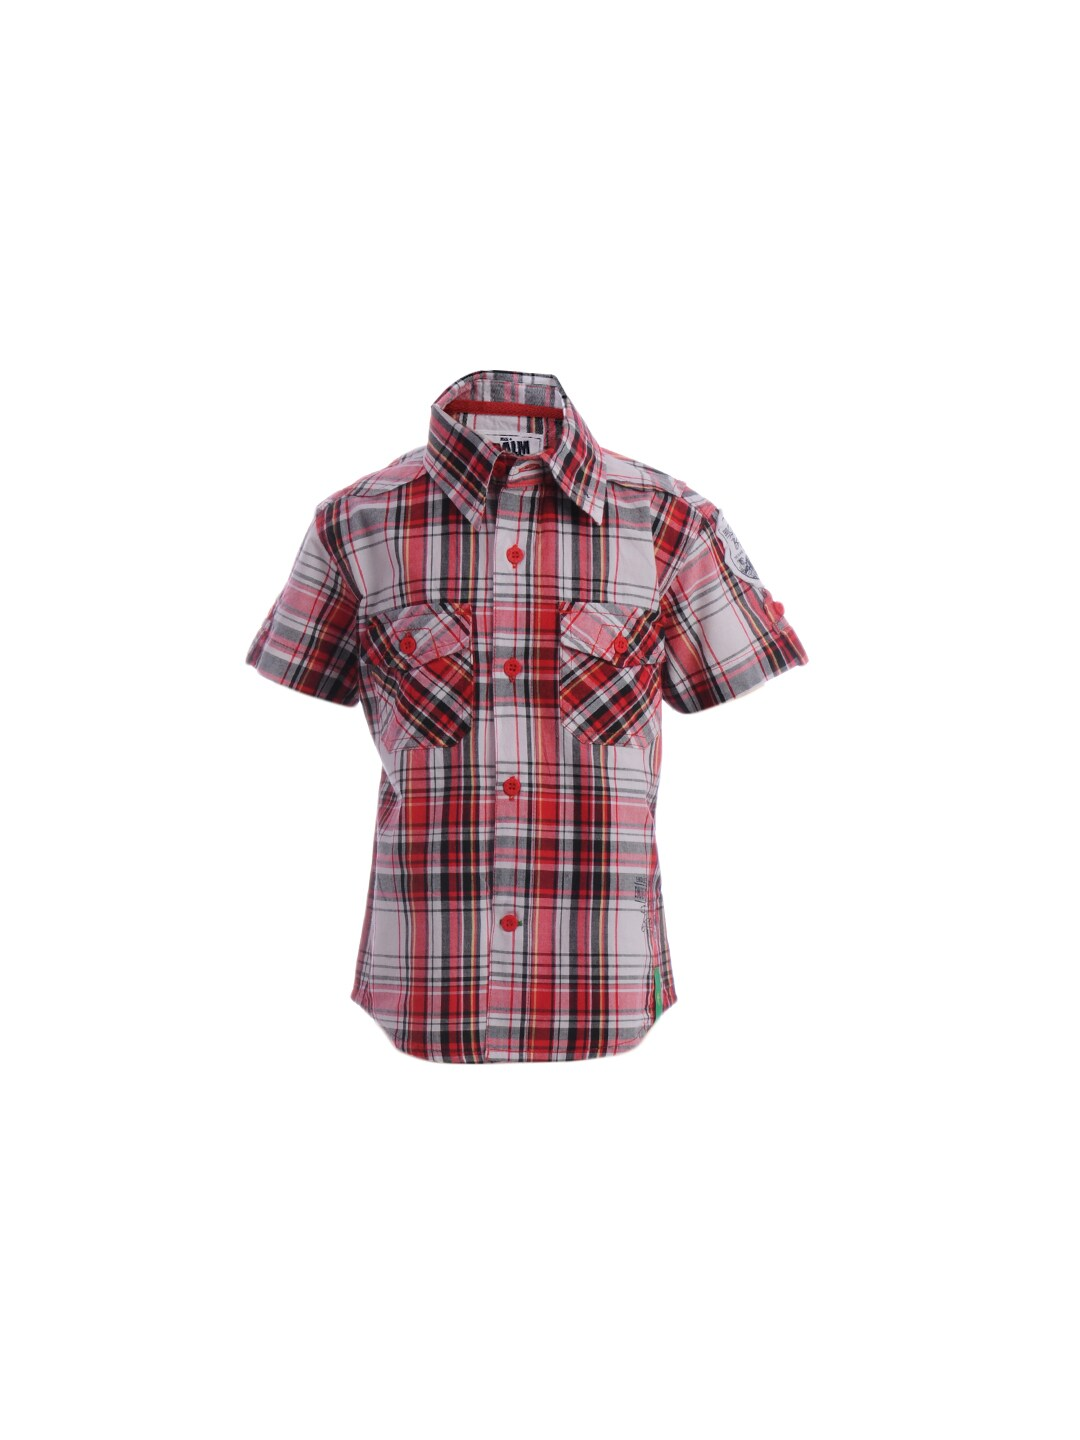

In [40]:
i = 0
for image in np.array(images)[idx][::-1]:
    i += 1
    display(DisplayImage(image, width="200px"))
    if i >= 5:
        break